# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [1]:
# ===============================
# 0. Импорты и установка устройства
# ===============================
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import models, transforms
from PIL import Image

from transformers import BertTokenizer, BertModel

from sklearn.model_selection import GroupShuffleSplit

import optuna

# Устанавливаем устройство (GPU, если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)

C:\Users\Deвайс\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Используемое устройство: cuda


In [2]:
# ===============================
# 1. Загрузка и предобработка данных
# ===============================

# Путь к данным
data_dir = Path(r'C:\Users\Deвайс\ML\to_upload') 

# Загрузка обучающего набора с описаниями
train_df = pd.read_csv(data_dir / "train_dataset.csv")
print("Train dataset (первые 5 строк):")
print(train_df.head())

# Загрузка краудсорсинговых аннотаций
crowd_df = pd.read_csv(
    data_dir / "CrowdAnnotations.tsv",
    sep="\t", header=None,
    names=["image_file", "query_id", "score", "yes", "no"]
)
print("Crowd annotations (первые 5 строк):")
print(crowd_df.head())

# Загрузка экспертных аннотаций
expert_df = pd.read_csv(
    data_dir / "ExpertAnnotations.tsv",
    sep="\t", header=None,
    names=["image_file", "query_id", "ex1", "ex2", "ex3"]
)
print("Expert annotations (первые 5 строк):")
print(expert_df.head())

# Загрузка тестовых запросов
test_queries_df = pd.read_csv(
    data_dir / "test_queries.csv",
    sep="|", header=None,
    names=["query_id", "query_text", "image"],
    skiprows=1
)
print("Test queries (первые 5 строк):")
print(test_queries_df.head())


Train dataset (первые 5 строк):
                       image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...  
Crowd annotations (первые 5 строк):
                  image_file                     query_id  score  yes  no
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2    1.0    3   0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2    0.0    0   3
2  1056338697

In [3]:
# Функция для фильтрации «проблемного» контента (например, связанного с детьми)
child_keywords = ['child', 'baby', 'kid', 'toddler', 'teenager', 'girls', 'boys']
def contains_child_keywords(text):
    if pd.isna(text):
        return False
    return any(keyword in text.lower() for keyword in child_keywords)

# Отфильтруем обучающий датасет (убираем строки с child-related контентом)
filtered_train_df = train_df[~train_df["query_text"].apply(contains_child_keywords)].reset_index(drop=True)
print("Filtered train dataset (без запрещённого контента):", filtered_train_df.shape)

Filtered train dataset (без запрещённого контента): (5057, 3)


In [4]:
# Аггрегация экспертных оценок (используем голосование большинства)
def aggregate_expert(row):
    ratings = [row["ex1"], row["ex2"], row["ex3"]]
    # Если минимум два рейтинга совпадают, возвращаем их значение, иначе NaN
    from collections import Counter
    count = Counter(ratings)
    most_common, cnt = count.most_common(1)[0]
    return most_common if cnt >= 2 else np.nan

expert_df["final_expert"] = expert_df.apply(aggregate_expert, axis=1)

# Аггрегация краудсорсинговых оценок: доля положительных голосов
crowd_df["crowd_score"] = crowd_df["yes"] / (crowd_df["yes"] + crowd_df["no"])

# Объединяем экспертные и краудсорсинговые оценки (например, вес экспертов = 0.6, крауд = 0.4)
merged_scores = pd.merge(
    expert_df[["image_file", "query_id", "final_expert"]],
    crowd_df[["image_file", "query_id", "crowd_score"]],
    on=["image_file", "query_id"],
    how="inner"
)
merged_scores["final_score"] = 0.6 * merged_scores["final_expert"] + 0.4 * merged_scores["crowd_score"]
# Нормализуем в [0,1]
min_val, max_val = merged_scores["final_score"].min(), merged_scores["final_score"].max()
merged_scores["final_score_norm"] = (merged_scores["final_score"] - min_val) / (max_val - min_val)

# Объединяем с описаниями из filtered_train_df
# Предполагаем, что столбцы для объединения: "image" и "query_id"
filtered_train_df = filtered_train_df.rename(columns={"image": "image_file"})
merged_df = pd.merge(filtered_train_df, merged_scores[["image_file", "query_id", "final_score_norm"]],
                     on=["image_file", "query_id"], how="inner")
print("Merged training dataset shape:", merged_df.shape)


Merged training dataset shape: (2087, 4)


In [5]:
merged_df['final_score_norm'].value_counts()

final_score_norm
0.272727    717
0.000000    516
1.000000    205
0.545455    170
0.606061    131
0.333333     72
0.666667     71
0.939394     53
0.727273     34
0.878788     17
0.393939     17
0.060606      4
0.309091      2
0.590909      2
0.636364      2
0.318182      2
0.618182      2
0.681818      2
0.363636      2
0.454545      1
0.045455      1
0.690909      1
Name: count, dtype: int64

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [6]:
# ===============================
# 2. Векторизация изображений и текстов
# ===============================

# Загрузка модели ResNet18 с использованием новых весов
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Убираем последний полностью связанный слой
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])

resnet18.eval().to(device)

# Преобразования для изображений
image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def extract_image_features(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Ошибка при загрузке изображения {img_path}: {e}")
        return None
    img_tensor = image_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        features = resnet18(img_tensor)
    # Приводим к вектору
    features = features.view(-1)
    return features.cpu().numpy()

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [7]:
import re

def clean_tokenize_text(text):
    """
    Очищает и токенизирует текст.
    - Приводит текст к нижнему регистру.
    - Удаляет ненужные символы и числа.
    """
    # Приводим текст к нижнему регистру
    text = text.lower()
    
    # Удаляем все символы, кроме букв и пробелов
    text = re.sub(r'[^a-zа-яё\s]', '', text)
    
    # Токенизация текста (разделение на слова)
    tokens = text.split()
    
    return " ".join(tokens)


In [8]:
from transformers import BertTokenizer, BertModel

# Загружаем токенизатор и модель BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

def extract_text_features(text):
    if pd.isna(text) or not isinstance(text, str):
        return None
    
    # Очистка текста
    cleaned_text = clean_tokenize_text(text)
    
    # Токенизация и векторизация с использованием BERT
    inputs = tokenizer(cleaned_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = bert_model(**inputs)
    
    # Используем вектор [CLS] (первый токен)
    cls_vector = outputs.last_hidden_state[:, 0, :].squeeze()
    return cls_vector.cpu().numpy()

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [9]:
# ===============================
# 3. Формирование обучающего набора
# ===============================
# Для каждого примера в merged_df получим объединённый вектор (изображение + текст)
# Если merged_df был сформирован ранее, удаляем строки с NaN в целевой переменной
merged_df = merged_df.dropna(subset=["final_score_norm"]).reset_index(drop=True)
image_folder = data_dir / "train_images"
X_list, y_list, groups = [], [], []
for _, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0], desc="Формирование обучающего набора"):
    img_path = image_folder / row["image_file"]
    img_feat = extract_image_features(str(img_path))
    if img_feat is None or img_feat.shape[0] != 512:
        continue
    txt_feat = extract_text_features(row["query_text"])
    if txt_feat is None or txt_feat.shape[0] != 768:
        continue
    combined = np.concatenate([img_feat, txt_feat])  # размер: 1280
    X_list.append(combined)
    y_list.append(row["final_score_norm"])
    groups.append(row["image_file"])

X = np.array(X_list)
y = np.array(y_list)
print("Размер обучающего набора X:", X.shape)
print("Размер целевой переменной y:", y.shape)


Формирование обучающего набора: 100%|██████████████████████████████████████████████| 2024/2024 [00:37<00:00, 53.33it/s]

Размер обучающего набора X: (2024, 1280)
Размер целевой переменной y: (2024,)


In [10]:
# 4. Разбиение на обучающую и тестовую выборки
# (Группируем по image_file, чтобы одно изображение не попало в обе выборки)
# ===============================
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
print("Размеры обучающей выборки:", X_train.shape, y_train.shape)
print("Размеры тестовой выборки:", X_test.shape, y_test.shape)


Размеры обучающей выборки: (1404, 1280) (1404,)
Размеры тестовой выборки: (620, 1280) (620,)


In [11]:
# ===============================
# 5. Подготовка данных для PyTorch
# ===============================
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().unsqueeze(1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return {"data": self.X[idx], "target": self.y[idx]}

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [12]:
# ===============================
# 6. Определение улучшенной модели и функции обучения с ранней остановкой
# ===============================
class ImprovedRegressionNet(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedRegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(128, 1)
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

def train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs=100, patience=20, min_delta=0.0):
    best_model_state = model.state_dict()  # Инициализация лучшего состояния модели
    best_val_loss = float("inf")
    epochs_no_improve = 0
    train_rmse_history = []
    val_rmse_history = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(batch["data"].to(device))
            loss_val = criterion(outputs, batch["target"].to(device))
            loss_val.backward()
            optimizer.step()
            running_loss += loss_val.item() * batch["data"].size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_rmse = sqrt(train_loss)
        train_rmse_history.append(train_rmse)

        # Валидация
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                outputs = model(batch["data"].to(device))
                loss_val = criterion(outputs, batch["target"].to(device))
                running_val_loss += loss_val.item() * batch["data"].size(0)
        val_loss = running_val_loss / len(val_loader.dataset)
        val_rmse = sqrt(val_loss)
        val_rmse_history.append(val_rmse)

        print(f"Epoch {epoch+1}/{n_epochs}: Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}")

        # Обновляем лучшее состояние, если улучшение достигнуто
        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(best_model_state)
    return model, {"train_rmse": train_rmse_history, "val_rmse": val_rmse_history}


In [13]:
# Разбиваем train_dataset на обучающую и валидационную (80/20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [16]:
# Инициализируем и обучаем модель
final_model = ImprovedRegressionNet(X_train.shape[1]).to(device)
optimizer_final = optim.Adam(final_model.parameters(), lr=0.001)
criterion_final = nn.MSELoss()

final_model, history = train_model(final_model, train_loader, val_loader,
                                   optimizer_final, criterion_final,
                                   n_epochs=100, patience=20, min_delta=0.0)

Epoch 1/100: Train RMSE: 0.4718, Val RMSE: 0.3986
Epoch 2/100: Train RMSE: 0.3690, Val RMSE: 0.3143
Epoch 3/100: Train RMSE: 0.3370, Val RMSE: 0.3090
Epoch 4/100: Train RMSE: 0.3154, Val RMSE: 0.3276
Epoch 5/100: Train RMSE: 0.2793, Val RMSE: 0.3180
Epoch 6/100: Train RMSE: 0.2796, Val RMSE: 0.3264
Epoch 7/100: Train RMSE: 0.2651, Val RMSE: 0.3084
Epoch 8/100: Train RMSE: 0.2615, Val RMSE: 0.3086
Epoch 9/100: Train RMSE: 0.2474, Val RMSE: 0.3160
Epoch 10/100: Train RMSE: 0.2350, Val RMSE: 0.3241
Epoch 11/100: Train RMSE: 0.2277, Val RMSE: 0.3258
Epoch 12/100: Train RMSE: 0.2361, Val RMSE: 0.3211
Epoch 13/100: Train RMSE: 0.2218, Val RMSE: 0.3212
Epoch 14/100: Train RMSE: 0.2190, Val RMSE: 0.3227
Epoch 15/100: Train RMSE: 0.2093, Val RMSE: 0.3328
Epoch 16/100: Train RMSE: 0.2142, Val RMSE: 0.3336
Epoch 17/100: Train RMSE: 0.2074, Val RMSE: 0.3240
Epoch 18/100: Train RMSE: 0.2045, Val RMSE: 0.3289
Epoch 19/100: Train RMSE: 0.2029, Val RMSE: 0.3252
Epoch 20/100: Train RMSE: 0.1945, Val RM

In [17]:
# Оценка на тестовой выборке
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
final_model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        outputs = final_model(batch["data"].to(device))
        loss_val = criterion_final(outputs, batch["target"].to(device))
        test_loss += loss_val.item() * batch["data"].size(0)
final_rmse = sqrt(test_loss / len(test_dataset))
print(f"Final Test RMSE: {final_rmse:.4f}")


Final Test RMSE: 0.3158


## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

Тестовый запрос: Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .
Лучшее изображение: 2167644298_100ca79f54.jpg


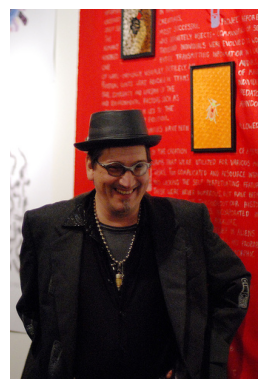

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

def find_best_image(query_text, image_features, text_features, image_filenames):
    """
    Ищет лучшее изображение для текстового запроса на основе косинусного сходства.
    
    :param query_text: Текст запроса
    :param image_features: Матрица векторов изображений (512-мерные)
    :param text_features: Матрица векторов текстов (768-мерные)
    :param image_filenames: Список имен файлов изображений
    :return: Лучшее изображение
    """
    # Векторизуем текстовый запрос
    query_vector = extract_text_features(query_text)
    if query_vector is None or query_vector.shape[0] != 768:
        print("Ошибка: Невозможно векторизовать текстовый запрос.")
        return None

    # Вычисляем косинусное сходство между запросом и текстами изображений
    text_similarities = cosine_similarity(query_vector.reshape(1, -1), text_features)
    
    # Выбираем изображение с наибольшим сходством
    best_match_idx = np.argmax(text_similarities)
    best_image_filename = image_filenames[best_match_idx]
    
    return best_image_filename

# ===============================
# Подготовка данных для поиска
# ===============================

image_filenames = merged_df["image_file"].tolist()  # Список имен файлов изображений

# Разделяем X (1280) на две части: изображения (512) и текст (768)
image_features = X[:, :512]  # Первые 512 элементов — это изображение
text_features = X[:, 512:]  # Оставшиеся 768 элементов — это текст

# ===============================
# Тестируем поиск изображения по запросу
# ===============================

test_query = test_queries_df.iloc[0]["query_text"]
print(f"Тестовый запрос: {test_query}")

# Находим подходящее изображение
best_image = find_best_image(test_query, image_features, text_features, image_filenames)
print(f"Лучшее изображение: {best_image}")

# Отображаем изображение
if best_image:
    img_path = data_dir / "train_images" / best_image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()


In [18]:
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import os
import matplotlib.pyplot as plt

# Функция для эмбеддинга текста
def get_text_embedding(input_text):
    tokenized = tokenizer.encode(input_text, max_length=512, truncation=True, add_special_tokens=True)
    padded = pad_sequence([torch.as_tensor(tokenized)], batch_first=True)

    # маска внимания
    attention_mask = padded > 0
    attention_mask = attention_mask.type(torch.LongTensor).to(device)

    # эмбеддинги
    with torch.no_grad():
        text_embedding = model_emb_txt(padded.to(device), attention_mask=attention_mask)[0][:, 0, :].cpu().numpy()
    return text_embedding[0].tolist()

# Функция для тестирования
def imag_test(query_text):
    text_embedding = get_text_embedding(query_text)
    
    # Добавляем текстовый эмбеддинг к изображению (как у друга, сложение вместо конкатенации)
    test['vector'] = test['image_vector'].apply(lambda x: np.array(x, dtype=np.float32) + np.array(text_embedding, dtype=np.float32))

    # Создание тензора
    test_vectors = np.stack(test['vector'].to_numpy())
    X_test_tensor = torch.tensor(test_vectors, dtype=torch.float32)

    # Вычисление предсказания с использованием регрессора
    test['pred'] = best_regressor.predict(X_test_tensor)
    
    # Получение изображения с максимальной оценкой
    max_score = test['pred'].max()
    image_path = test[test['pred'] == test['pred'].max()]['image'].values[0]
    return max_score, image_path

# Функция для вывода изображения по запросу
def display_image_with_caption(query_text):
    text = clean_tokenize_text(query_text)
    
    # Проверка наличия запрета на изображение
    if any(i in text for i in child_keywords):
        print(query_text)
        print('Изображение не доступно в данном регионе')
    else:
        max_score, image_path = imag_test(text)
        fig, ax = plt.subplots(figsize=(6, 6))
        image_path = os.path.join(TEST_IMAGES, image_path)
        
        # Загружаем изображение
        try:
            img = Image.open(image_path)
            ax.imshow(img)
            ax.set_title(query_text, fontsize=12)
            ax.axis('off')
            plt.show()
            print(f'Мера соответствия изображения: {max_score:.4f}')
        except Exception as e:
            print(f"Ошибка при загрузке изображения: {e}")

# Код для получения эмбеддингов изображений и их обработки
test_images_folder = data_dir / "test_images"
test_image_files = list(test_images_folder.glob("*.jpg"))
test_image_embeds = {}

# Получаем эмбеддинги для всех изображений
for path in test_image_files:
    emb = extract_image_features(str(path))
    if emb is not None and emb.shape[0] == 512:  # Убедитесь, что размер эмбеддингов изображений правильный
        test_image_embeds[path.name] = emb
print(f"Вычислено эмбеддингов для {len(test_image_embeds)} тестовых изображений.")

# Формируем список запросов
queries = [
    "A large tan dog sits on a grassy hill .",
    "A large yellow dog is sitting on a hill .",
    "The dog is sitting on the side of the hill .",
    "A white dog and a black dog in a field .",
    "A white dog with a branch in his mouth and a black dog .",
    "A white dog with a stick in his mouth standing next to a black dog .",
    "Two dogs are standing next to each other , and the white dog has a stick in its mouth .",
    "Two dogs stand in the brown grass .",
    "Two girls in pink are playing on yellow playground bars .",
    "Two girls on a jungle gym ."
]

# Итерируем по запросам и выводим результаты
for query in queries:
    display_image_with_caption(query)


Вычислено эмбеддингов для 100 тестовых изображений.


NameError: name 'model_emb_txt' is not defined

Вычислено эмбеддингов для 100 тестовых изображений.
Запрос: A large tan dog sits on a grassy hill .
Оценки для изображений: [0.1228 0.1386 0.3453 0.238  0.3469 0.0791 0.1057 0.6323 0.2067 0.4844
 0.0389 0.0143 0.0955 0.0613 0.1491 0.2035 0.1482 0.1992 0.1842 0.1064
 0.0696 0.1921 0.3925 0.3671 0.1038 0.2749 0.3767 0.0932 0.3857 0.1953
 0.0702 0.1408 0.2769 0.1152 0.0299 0.2678 0.239  0.1898 0.6772 0.2279
 0.1755 0.558  0.2956 0.542  0.3077 0.2376 0.0805 0.4481 0.1372 0.6472
 0.3074 0.0589 0.1088 0.0574 0.1975 0.4642 0.2975 0.5495 0.0901 0.2402
 0.2883 0.2848 0.2236 0.0839 0.1433 0.4728 0.2476 0.2581 0.1919 0.4465
 0.1895 0.4003 0.1717 0.201  0.4704 0.7499 0.1417 0.2341 0.4173 0.1947
 0.2621 0.3199 0.23   0.5317 0.335  0.3895 0.0735 0.2405 0.0256 0.0448
 0.3846 0.5487 0.2943 0.1872 0.05   0.1325 0.3211 0.1199 0.2649 0.5909]

Запрос: A large tan dog sits on a grassy hill .
Лучшее изображение: 3514297698_0512623955.jpg с оценкой: 0.7499


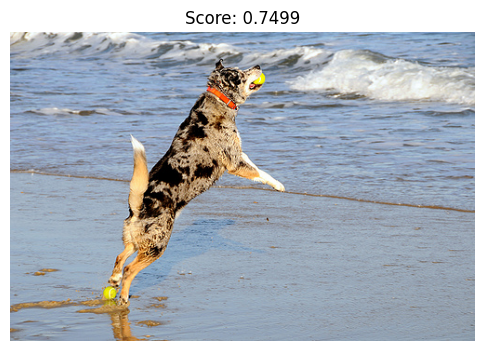

Запрос: A large yellow dog is sitting on a hill .
Оценки для изображений: [ 0.0771  0.0881  0.273   0.1639  0.2471  0.0773  0.081   0.5419  0.1575
  0.5798  0.0222 -0.011   0.0601  0.0658  0.1256  0.1414  0.0878  0.1414
  0.1766  0.0925  0.0627  0.1478  0.2487  0.3876  0.0512  0.1773  0.3279
  0.0545  0.292   0.1568  0.0754  0.1264  0.1887  0.0852  0.0287  0.2788
  0.1993  0.1623  0.553   0.2102  0.1263  0.4117  0.2656  0.537   0.272
  0.1845  0.0965  0.4025  0.1042  0.5728  0.2145  0.0573  0.1147  0.0486
  0.164   0.3464  0.2447  0.5221  0.108   0.157   0.2439  0.1956  0.1052
  0.104   0.1464  0.4369  0.1819  0.1695  0.166   0.3211  0.1808  0.3442
  0.1492  0.1468  0.3705  0.7016  0.1502  0.1753  0.3627  0.1266  0.3411
  0.2175  0.1651  0.4475  0.2714  0.2793  0.0525  0.1834  0.0365  0.0512
  0.3546  0.4535  0.2481  0.2007  0.0447  0.1022  0.2332  0.0923  0.2125
  0.6299]

Запрос: A large yellow dog is sitting on a hill .
Лучшее изображение: 3514297698_0512623955.jpg с оценкой: 0.7016

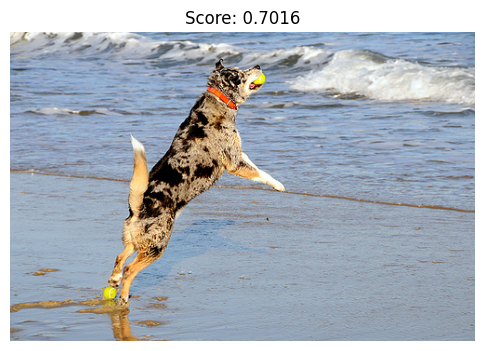

Запрос: The dog is sitting on the side of the hill .
Оценки для изображений: [0.1424 0.0793 0.2333 0.1791 0.2497 0.0433 0.0854 0.5391 0.2345 0.4861
 0.0252 0.0016 0.1121 0.0667 0.1097 0.1343 0.1648 0.2033 0.1063 0.0986
 0.0706 0.1831 0.2921 0.3601 0.0723 0.1735 0.3468 0.0837 0.4035 0.2169
 0.061  0.1127 0.1722 0.1495 0.0425 0.2016 0.2077 0.1523 0.5414 0.2118
 0.1302 0.4895 0.2501 0.4737 0.3296 0.2121 0.0859 0.4062 0.0884 0.5838
 0.2366 0.0844 0.1207 0.0623 0.2011 0.3444 0.2492 0.3853 0.142  0.2202
 0.2166 0.1971 0.1579 0.0894 0.1713 0.3943 0.2601 0.1542 0.1997 0.4675
 0.1363 0.3223 0.1865 0.1429 0.4194 0.6463 0.1261 0.2072 0.2844 0.135
 0.2733 0.2175 0.1965 0.4532 0.3728 0.3344 0.0793 0.2046 0.0397 0.0547
 0.3726 0.4544 0.258  0.1767 0.0621 0.1041 0.2301 0.154  0.2121 0.5903]

Запрос: The dog is sitting on the side of the hill .
Лучшее изображение: 3514297698_0512623955.jpg с оценкой: 0.6463


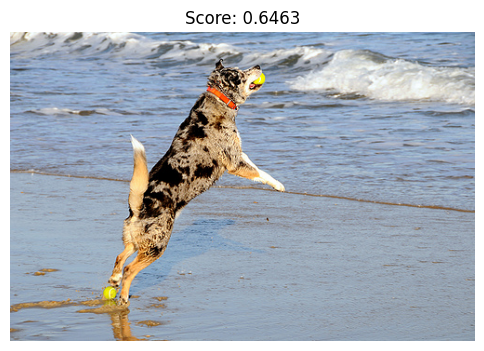

Запрос: A white dog and a black dog in a field .
Оценки для изображений: [ 1.160e-02  1.109e-01  3.736e-01  3.519e-01  4.270e-01  4.940e-02
  3.520e-02  6.395e-01  1.331e-01  5.495e-01  3.630e-02 -1.790e-02
  1.140e-02  7.510e-02  2.873e-01  2.370e-01  6.420e-02  2.251e-01
  5.510e-02  8.580e-02  4.070e-02  1.331e-01  4.462e-01  3.211e-01
  9.920e-02  4.181e-01  5.589e-01  6.730e-02  2.731e-01  1.000e-04
  6.250e-02  2.962e-01  2.564e-01  9.250e-02  3.000e-03  6.100e-02
  2.763e-01  3.693e-01  4.750e-01  2.467e-01  3.791e-01  5.561e-01
  5.486e-01  5.177e-01  1.293e-01  1.943e-01  5.460e-02  4.095e-01
  1.298e-01  5.949e-01  5.391e-01  2.220e-02  2.358e-01  7.820e-02
  1.428e-01  4.987e-01  6.158e-01  5.101e-01  8.910e-02  2.007e-01
  1.671e-01  4.550e-01  6.240e-02  3.810e-02  2.368e-01  3.517e-01
  2.315e-01  2.409e-01  2.459e-01  4.066e-01  1.047e-01  6.175e-01
  1.294e-01  3.693e-01  5.365e-01  7.145e-01  1.391e-01  1.063e-01
  3.093e-01  1.098e-01  1.920e-01  3.655e-01  8.450e-02 

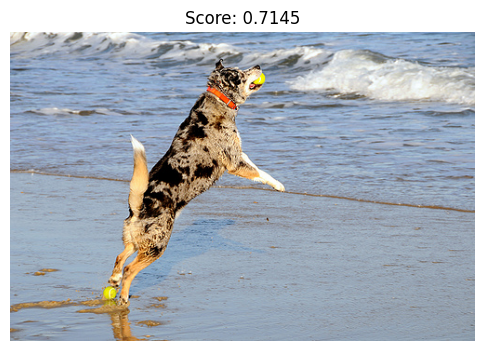

Запрос: A white dog with a branch in his mouth and a black dog .
Оценки для изображений: [ 0.004   0.09    0.4041  0.2605  0.3809  0.0398  0.0339  0.5526  0.1071
  0.5008  0.0324 -0.0223 -0.0096  0.0712  0.1698  0.2068  0.0597  0.1544
  0.0647  0.0564  0.0213  0.0694  0.3362  0.2904  0.1084  0.3314  0.5601
  0.0407  0.2347 -0.0181  0.0557  0.2184  0.2293  0.0575  0.0054  0.1016
  0.1995  0.3203  0.4317  0.1629  0.2715  0.4677  0.4741  0.5257  0.1249
  0.1373  0.0579  0.3368  0.1364  0.501   0.4269  0.0174  0.1976  0.0541
  0.09    0.4698  0.5221  0.4996  0.0437  0.132   0.2076  0.3097  0.0301
  0.0489  0.1657  0.3422  0.1817  0.2142  0.168   0.2956  0.0848  0.5693
  0.1109  0.3818  0.5051  0.6123  0.1461  0.0802  0.2208  0.0825  0.2112
  0.3708  0.0483  0.4197  0.037   0.3271  0.192   0.0466  0.1189  0.0593
  0.1327  0.5547  0.3866  0.1621  0.0318  0.1127  0.3358  0.0325  0.3043
  0.3193]

Запрос: A white dog with a branch in his mouth and a black dog .
Лучшее изображение: 3514297698_0

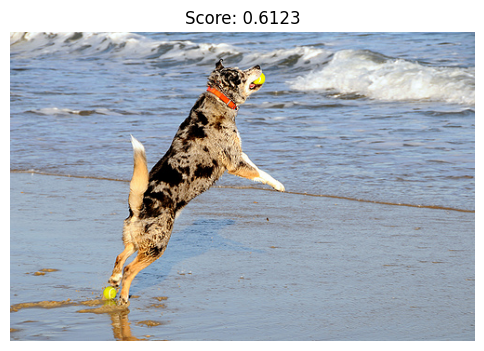

Запрос: A white dog with a stick in his mouth standing next to a black dog .
Оценки для изображений: [ 0.0394  0.0778  0.4067  0.1675  0.2868  0.0797  0.0342  0.499   0.2109
  0.6658  0.0388 -0.0134  0.0085  0.0905  0.1309  0.1367  0.1056  0.2689
  0.1248  0.0712  0.0164  0.1456  0.1784  0.4913  0.1265  0.2028  0.6656
  0.0603  0.3607  0.0798  0.12    0.24    0.1614  0.0984  0.0217  0.2005
  0.2742  0.2969  0.4602  0.2052  0.1338  0.5762  0.3814  0.6205  0.2737
  0.1911  0.1366  0.3564  0.0694  0.5133  0.3115  0.0542  0.1983  0.082
  0.2095  0.3669  0.3704  0.4798  0.0897  0.1735  0.2669  0.2314  0.0844
  0.1012  0.2271  0.4925  0.252   0.2501  0.2021  0.418   0.1193  0.4227
  0.1477  0.2301  0.4614  0.5908  0.1833  0.1455  0.2326  0.1004  0.3415
  0.3434  0.0677  0.4414  0.2348  0.2785  0.1517  0.0789  0.1171  0.0219
  0.2074  0.4601  0.2608  0.2625  0.0276  0.1435  0.2317  0.0839  0.2569
  0.4694]

Запрос: A white dog with a stick in his mouth standing next to a black dog .
Лучшее из

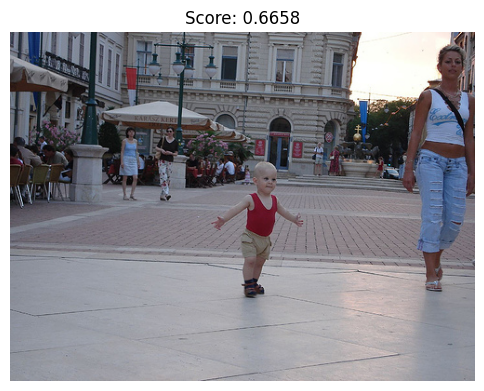

Запрос: Two dogs are standing next to each other , and the white dog has a stick in its mouth .
Оценки для изображений: [ 0.0186  0.0796  0.3025  0.1222  0.2075  0.0738  0.052   0.4325  0.1394
  0.3757  0.0197 -0.0166  0.0108  0.07    0.1027  0.1079  0.0508  0.1124
  0.1215  0.0407  0.0455  0.0934  0.1386  0.3208  0.0397  0.164   0.3816
  0.0314  0.1695  0.0816  0.0849  0.1223  0.1457  0.0354  0.0201  0.2407
  0.1297  0.1833  0.3959  0.1343  0.1305  0.3235  0.284   0.4597  0.1839
  0.134   0.0974  0.3348  0.0477  0.4522  0.1788  0.0265  0.102   0.0345
  0.1141  0.286   0.281   0.4486  0.0385  0.092   0.2293  0.1413  0.0659
  0.07    0.1067  0.4031  0.108   0.1429  0.1586  0.2139  0.1446  0.3678
  0.0901  0.1562  0.3926  0.5301  0.2101  0.0829  0.2438  0.0843  0.3532
  0.2068  0.0766  0.2855  0.1343  0.2568  0.0581  0.0865  0.0502  0.0372
  0.1873  0.3987  0.2387  0.1577  0.0309  0.1099  0.2234  0.0484  0.1754
  0.5293]

Запрос: Two dogs are standing next to each other , and the white d

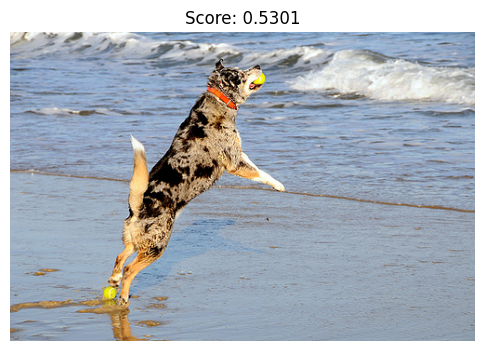

Запрос: Two dogs stand in the brown grass .
Оценки для изображений: [0.0445 0.1911 0.3781 0.392  0.5112 0.0776 0.0995 0.7711 0.153  0.2982
 0.041  0.0326 0.0833 0.0553 0.1703 0.2921 0.1099 0.1985 0.1719 0.0996
 0.0942 0.1536 0.4514 0.2841 0.1437 0.441  0.368  0.1211 0.3458 0.1159
 0.1116 0.1995 0.4071 0.1442 0.008  0.1776 0.2893 0.2949 0.8074 0.2749
 0.3199 0.5904 0.4659 0.454  0.2413 0.1949 0.0767 0.5433 0.2069 0.753
 0.4446 0.0508 0.159  0.0888 0.1334 0.5833 0.5043 0.6588 0.0813 0.165
 0.2642 0.3993 0.2048 0.0382 0.1762 0.4307 0.2024 0.3441 0.1747 0.4405
 0.1802 0.5877 0.098  0.2905 0.6113 0.8516 0.1321 0.148  0.5326 0.1956
 0.202  0.354  0.2146 0.6386 0.1698 0.4755 0.1207 0.1717 0.0505 0.0618
 0.3224 0.6938 0.4295 0.1347 0.05   0.1263 0.4724 0.0739 0.2975 0.6257]

Запрос: Two dogs stand in the brown grass .
Лучшее изображение: 3514297698_0512623955.jpg с оценкой: 0.8516


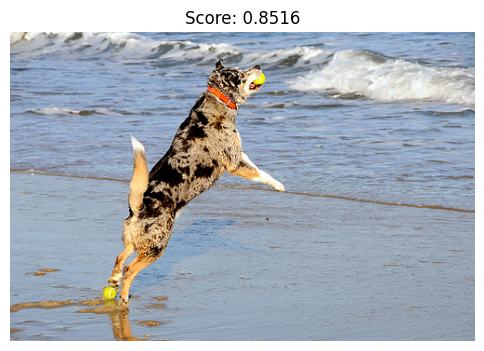

Запрос: Two girls in pink are playing on yellow playground bars .
Оценки для изображений: [ 0.0182  0.1094  0.3953  0.1823  0.2602  0.1003  0.0963  0.5899  0.1229
  0.5203  0.0353 -0.0049  0.0262  0.0795  0.1765  0.1887  0.0546  0.1144
  0.1399  0.0563  0.0634  0.1252  0.2181  0.2627  0.0627  0.2267  0.4792
  0.044   0.1785  0.0688  0.0991  0.1493  0.2141  0.0498  0.0326  0.2638
  0.2271  0.2745  0.5102  0.2284  0.1867  0.4508  0.447   0.4644  0.1996
  0.1346  0.1516  0.4173  0.0674  0.5737  0.2659  0.0314  0.1496  0.054
  0.1033  0.3819  0.3941  0.5379  0.0789  0.1233  0.3285  0.2371  0.0722
  0.0888  0.1166  0.3829  0.2021  0.2075  0.2441  0.213   0.1605  0.4731
  0.1243  0.226   0.4847  0.7123  0.2441  0.1296  0.3028  0.1358  0.3198
  0.2648  0.1383  0.4208  0.1149  0.2818  0.0753  0.11    0.0697  0.0673
  0.2874  0.4681  0.3423  0.1889  0.0496  0.1369  0.2967  0.0727  0.2929
  0.5522]

Запрос: Two girls in pink are playing on yellow playground bars .
Лучшее изображение: 3514297698_

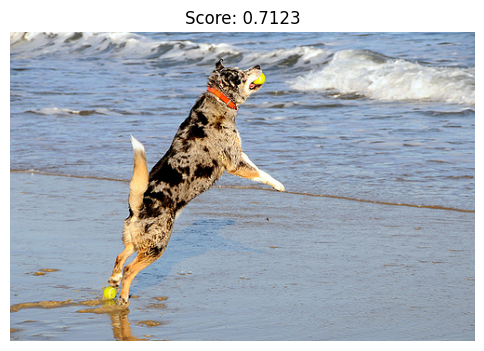

Запрос: Two girls on a junglezzz gym .
Оценки для изображений: [ 0.1315  0.1263  0.4184  0.1649  0.2111  0.1025  0.0054  0.506   0.2479
  0.6766  0.0386 -0.0101  0.016   0.0738  0.1712  0.1613  0.2085  0.2255
  0.0801  0.1977  0.0202  0.2158  0.2191  0.3726  0.1653  0.2155  0.7004
  0.0513  0.3535  0.112   0.0811  0.2514  0.1277  0.057   0.0229  0.1216
  0.2524  0.2765  0.3919  0.1467  0.1454  0.6582  0.2824  0.5876  0.2088
  0.1845  0.1004  0.2257  0.0472  0.4914  0.4743  0.0981  0.217   0.0928
  0.2094  0.3741  0.2937  0.3028  0.1373  0.3528  0.297   0.3049  0.125
  0.128   0.1673  0.5491  0.3608  0.1885  0.4043  0.5555  0.0351  0.3018
  0.2446  0.2053  0.3598  0.5836  0.1205  0.1735  0.0957  0.1096  0.2241
  0.4243  0.1026  0.4083  0.2833  0.153   0.2731  0.0977  0.2476  0.0285
  0.198   0.4087  0.2256  0.2451  0.0771  0.2314  0.1366  0.1058  0.3417
  0.4393]

Запрос: Two girls on a junglezzz gym .
Лучшее изображение: 2517284816_9b8fd3c6b6.jpg с оценкой: 0.7004


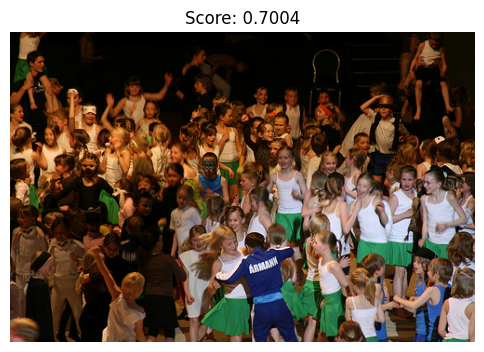

In [21]:
def search_best_image(query_text, image_embeds, model):
    txt_emb = extract_text_features(query_text)
    if txt_emb is None or txt_emb.shape[0] != 768:
        print(f"Ошибка в векторизации запроса: {query_text}")
        return None, None

    img_names = list(image_embeds.keys())
    img_matrix = np.stack([image_embeds[name] for name in img_names], axis=0)
    n_images = img_matrix.shape[0]
    txt_matrix = np.tile(txt_emb, (n_images, 1))
    combined_matrix = np.concatenate([img_matrix, txt_matrix], axis=1)
    combined_tensor = torch.from_numpy(combined_matrix).float().to(device)
    
    with torch.no_grad():
        scores = model(combined_tensor).cpu().numpy().flatten()
    
    # Выводим распределение оценок для отладки
    print(f"Запрос: {query_text}\nОценки для изображений: {np.round(scores, 4)}")
    
    best_idx = np.argmax(scores)
    best_image = img_names[best_idx]
    best_score = scores[best_idx]
    return best_image, best_score


# Предположим, что у вас уже вычислены эмбеддинги тестовых изображений:
# Например, если test_images_folder – путь к тестовой папке,
# то можно сделать следующее (один раз):
test_images_folder = data_dir / "test_images"  # например, путь к тестовым изображениям
test_image_files = list(test_images_folder.glob("*.jpg"))
test_image_embeds = {}
for path in test_image_files:
    emb = extract_image_features(str(path))
    if emb is not None and emb.shape[0] == 512:
        test_image_embeds[path.name] = emb
print(f"Вычислено эмбеддингов для {len(test_image_embeds)} тестовых изображений.")

# Итерируем по запросам и выводим результаты
for query in queries:
    best_img, score = search_best_image(query, test_image_embeds, final_model)  # или improved_model/другая модель
    if best_img is None:
        print(f"Запрос: {query}\nНе удалось найти релевантное изображение.\n")
        continue
    print(f"\nЗапрос: {query}")
    print(f"Лучшее изображение: {best_img} с оценкой: {score:.4f}")
    # Отображаем изображение
    try:
        img = Image.open(test_images_folder / best_img).convert("RGB")
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Score: {score:.4f}")
        plt.show()
    except Exception as e:
        print(f"Ошибка при открытии изображения {best_img}: {e}")

In [ ]:
def search_best_image(query_text, image_embeds, model):
    txt_emb = extract_text_features(query_text)
    if txt_emb is None or txt_emb.shape[0] != 768:
        print(f"Ошибка в векторизации запроса: {query_text}")
        return None, None

    img_names = list(image_embeds.keys())
    img_matrix = np.stack([image_embeds[name] for name in img_names], axis=0)
    n_images = img_matrix.shape[0]
    txt_matrix = np.tile(txt_emb, (n_images, 1))
    combined_matrix = np.concatenate([img_matrix, txt_matrix], axis=1)
    combined_tensor = torch.from_numpy(combined_matrix).float().to(device)
    
    with torch.no_grad():
        scores = model(combined_tensor).cpu().numpy().flatten()
    
    # Выводим распределение оценок для отладки
    print(f"Запрос: {query_text}\nОценки для изображений: {np.round(scores, 4)}")
    
    best_idx = np.argmax(scores)
    best_image = img_names[best_idx]
    best_score = scores[best_idx]
    return best_image, best_score


## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска